# Project in Machine Learning Class: Predict user's review sentiment

### John Koumentis, MTN2012

In [1]:
import numpy as np
import pandas as pd
from collections import Counter
import seaborn as sns

import string

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import spacy

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn import metrics

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\John\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Load and pre-process data

The data used comes from the 'Amazon Cell Phones Reviews' dataset found in Kaggle (https://www.kaggle.com/grikomsn/amazon-cell-phones-reviews)

In [2]:
#Read the reviews dataset
df = pd.read_csv('20191226-reviews.csv')
df = df.drop('name', axis=1)

In [3]:
#Check for missing data
missing_data = df.isnull().sum()
print(missing_data)

asin                0
rating              0
date                0
verified            0
title              14
body               21
helpfulVotes    40771
dtype: int64


In [4]:
#Remove empty reviews
empty_reviews = np.where(pd.isnull(df.body))
df.drop(list(empty_reviews)[0],inplace=True)
empty_reviews

(array([ 9445, 18055, 19749, 20892, 21149, 21887, 22917, 29501, 30010,
        35596, 36845, 43415, 45899, 46470, 51628, 52176, 55171, 57837,
        61074, 62205, 64371], dtype=int64),)

In [5]:
df.head(10)

,asin,rating,date,verified,title,body,helpfulVotes
0,B0000SX2UC,3,"October 11, 2005",False,"Def not best, but not worst",I had the Samsung A600 for awhile which is abs...,1.0
1,B0000SX2UC,1,"January 7, 2004",False,Text Messaging Doesn't Work,Due to a software issue between Nokia and Spri...,17.0
2,B0000SX2UC,5,"December 30, 2003",False,Love This Phone,"This is a great, reliable phone. I also purcha...",5.0
3,B0000SX2UC,3,"March 18, 2004",False,"Love the Phone, BUT...!","I love the phone and all, because I really did...",1.0
4,B0000SX2UC,4,"August 28, 2005",False,"Great phone service and options, lousy case!",The phone has been great for every purpose it ...,1.0
5,B0000SX2UC,4,"September 25, 2005",False,Worked great for me,"Hello, I have this phone and used it until I d...",NaN
6,B0000SX2UC,5,"April 16, 2004",False,Wanna cool Nokia? You have it here!,Cool. Cheap. Color: 3 words that describe the ...,2.0
7,B0000SX2UC,4,"April 3, 2004",False,Problem with 3588i universal headset,"The 3599i is overall a nice phone, except that...",2.0
8,B0000SX2UC,5,"November 24, 2003",False,cool phone!!!!!!!!,"I've never owned a Nokia phone before, so this...",7.0
9,B0000SX2UC,3,"February 2, 2004",False,Pissed off-a little bit,ok well im in school and i need the text messa...,3.0


In [6]:
#Isolate body and rating columns in a new dataset
reviews_dataset = pd.DataFrame({'reviews':df.body.values, 'ratings':df.rating.values})
#reviews_dataset.to_csv('reviews.csv')
reviews_dataset.head()

,reviews,ratings
0,I had the Samsung A600 for awhile which is abs...,3
1,Due to a software issue between Nokia and Spri...,1
2,"This is a great, reliable phone. I also purcha...",5
3,"I love the phone and all, because I really did...",3
4,The phone has been great for every purpose it ...,4


After removing the lines containing the empty reviews and creating a new dataset by keeping only the reviews and ratings column, the reviews column was loaded in XLSX format at https://translate.google.gr/?hl=el&sl=auto&tl=el&op=docs and translated. The output was an HTML table that was launched via Excel and stored in CSV format with name 'translate.csv'.

In [7]:
translated = pd.read_csv('translate.csv',header=None)
reviews_dataset.insert(loc=1, column='greek', value=translated)
reviews_dataset.head(10)

,reviews,greek,ratings
0,I had the Samsung A600 for awhile which is abs...,Είχα το Samsung A600 για λίγο που είναι απόλυτ...,3
1,Due to a software issue between Nokia and Spri...,Λόγω ενός προβλήματος λογισμικού μεταξύ της No...,1
2,"This is a great, reliable phone. I also purcha...","Αυτό είναι ένα υπέροχο, αξιόπιστο τηλέφωνο. Αγ...",5
3,"I love the phone and all, because I really did...","Λατρεύω το τηλέφωνο και όλα, γιατί πραγματικά ...",3
4,The phone has been great for every purpose it ...,Το τηλέφωνο ήταν τέλειο για κάθε σκοπό που προ...,4
5,"Hello, I have this phone and used it until I d...","Γεια σας, έχω αυτό το τηλέφωνο και το χρησιμοπ...",4
6,Cool. Cheap. Color: 3 words that describe the ...,Δροσερός. Φτηνός. Χρώμα: 3 λέξεις που περιγράφ...,5
7,"The 3599i is overall a nice phone, except that...","Το 3599i είναι γενικά ένα ωραίο τηλέφωνο, εκτό...",4
8,"I've never owned a Nokia phone before, so this...","Δεν είχα ποτέ προηγουμένως τηλέφωνο Nokia, γι ...",5
9,ok well im in school and i need the text messa...,"εντάξει, είμαι στο σχολείο και χρειάζομαι τα γ...",3


In [8]:
#Clean reviews text
punctuation = set(string.punctuation)
nlp = spacy.load('el_core_news_sm')

def clean_text(text):
    # Convert the text into lowercase
    text = text.lower()
    # Split into list
    wordList = text.split()
    # Remove punctuation
    wordList = ["".join(x for x in word if (x=="'")|(x not in punctuation)) for word in wordList]
    # Remove stopwords
    wordList = [word for word in wordList if word not in stopwords.words('greek')]
    # Lemmatisation
    cleaned_text = nlp(" ".join(wordList))
    cleaned_text = [token.lemma_ for token in cleaned_text]
    return " ".join(cleaned_text)

Due to long execution time the results of the following cell execution were stored in the cleaned.csv file, to get retrieved directly from there.

In [9]:
#import time
#start = time.process_time()
#reviews_dataset['cleaned_text'] = reviews_dataset['greek'].apply(clean_text)
#print(time.process_time() - start)
#reviews_dataset.to_csv('cleaned.csv')
reviews_dataset = pd.read_csv('cleaned.csv',index_col=0)

C:\Users\John\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='ratings', ylabel='count'>

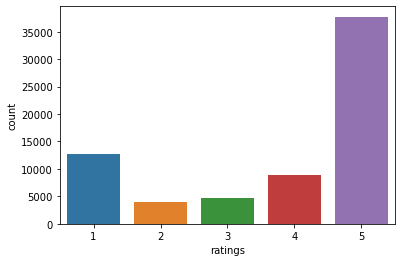

In [10]:
# Check the ratings count

sns.countplot(reviews_dataset['ratings'])

The `4` and `5` star (positive) ratings combined are more than the `1`,`2` ones (negative) combined. Hence, I decided to add the `3` star ratings to the negative ratings. In order to simplify the situation, I replaced the `4`,`5` star ratings with the label `1`, to indicate positive sentiment and the `1`,`2`,`3` star ratings with the label `0`, to indicate negative sentiment.

In [11]:
sentiment_dict = {1:0, 2:0, 3:0, 4:1, 5:1}
reviews_dataset['ratings'].replace(sentiment_dict,inplace=True)
reviews_dataset.head(10)

,reviews,greek,ratings,cleaned_text
0,I had the Samsung A600 for awhile which is abs...,Είχα το Samsung A600 για λίγο που είναι απόλυτ...,0,έχω samsung a600 λίγο είναι απόλυτος doo doo μ...
1,Due to a software issue between Nokia and Spri...,Λόγω ενός προβλήματος λογισμικού μεταξύ της No...,0,λόγω ενός προβλήματος λογισμικός μεταξύ της no...
2,"This is a great, reliable phone. I also purcha...","Αυτό είναι ένα υπέροχο, αξιόπιστο τηλέφωνο. Αγ...",1,αυτό είναι ένα υπέροχος αξιόπιστος τηλέφωνο αγ...
3,"I love the phone and all, because I really did...","Λατρεύω το τηλέφωνο και όλα, γιατί πραγματικά ...",0,λατρεύω τηλέφωνο όλος γιατί πραγματικά χρειαζά...
4,The phone has been great for every purpose it ...,Το τηλέφωνο ήταν τέλειο για κάθε σκοπό που προ...,1,τηλέφωνο ήταν τέλειος κάθε σκοπό προσφέρω εκτό...
5,"Hello, I have this phone and used it until I d...","Γεια σας, έχω αυτό το τηλέφωνο και το χρησιμοπ...",1,γειο σας έχω αυτό τηλέφωνο χρησιμοποίησα μέχρι...
6,Cool. Cheap. Color: 3 words that describe the ...,Δροσερός. Φτηνός. Χρώμα: 3 λέξεις που περιγράφ...,1,δροσερός φτηνό χρώμα 3 λέξει περιγράφω τέλειο ...
7,"The 3599i is overall a nice phone, except that...","Το 3599i είναι γενικά ένα ωραίο τηλέφωνο, εκτό...",1,3599i είναι γενικά ένα ωραίος τηλέφωνο εκτός α...
8,"I've never owned a Nokia phone before, so this...","Δεν είχα ποτέ προηγουμένως τηλέφωνο Nokia, γι ...",1,έχω ποτέ προηγουμένως τηλέφωνος nokia γι ' αυτ...
9,ok well im in school and i need the text messa...,"εντάξει, είμαι στο σχολείο και χρειάζομαι τα γ...",0,εντάξω είμαι σχολείο χρειάζομαι γραπτά μηνύματ...


C:\Users\John\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='ratings', ylabel='count'>

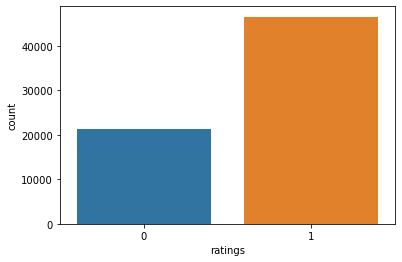

In [12]:
sns.countplot(reviews_dataset['ratings'])

In [13]:
missing_data = reviews_dataset.isnull().sum()
print(missing_data)

reviews          0
greek            0
ratings          0
cleaned_text    12
dtype: int64


In [14]:
nans = np.where(pd.isnull(reviews_dataset.cleaned_text))
reviews_dataset.drop(list(nans)[0],inplace=True)
empty_reviews

(array([ 9445, 18055, 19749, 20892, 21149, 21887, 22917, 29501, 30010,
        35596, 36845, 43415, 45899, 46470, 51628, 52176, 55171, 57837,
        61074, 62205, 64371], dtype=int64),)

In [15]:
#Isolate cleaned text and ratings columns in a new dataset
reviews = pd.DataFrame({'reviews':reviews_dataset.cleaned_text.values, 'ratings':reviews_dataset.ratings.values})
#reviews_dataset.to_csv('reviews.csv')
reviews.head()

,reviews,ratings
0,έχω samsung a600 λίγο είναι απόλυτος doo doo μ...,0
1,λόγω ενός προβλήματος λογισμικός μεταξύ της no...,0
2,αυτό είναι ένα υπέροχος αξιόπιστος τηλέφωνο αγ...,1
3,λατρεύω τηλέφωνο όλος γιατί πραγματικά χρειαζά...,0
4,τηλέφωνο ήταν τέλειος κάθε σκοπό προσφέρω εκτό...,1


In [16]:
greek_reviews = reviews_dataset.greek
labels = reviews_dataset.ratings

## Check Positive and Negative usage of words

In [17]:
# Create three Counter objects to store positive, negative and total counts
positive_counts = Counter()
negative_counts = Counter()
total_counts = Counter()

In [18]:
# Loop over all the words in all the reviews and increment the counts in the appropriate counter objects
for i in range(len(reviews)):
    try:
        for word in greek_reviews[i].split(" "):
            total_counts[word] += 1
            if labels[i] == 1:
                positive_counts[word] += 1
            else:
                negative_counts[word] += 1
    except KeyError:
        pass

In [19]:
pos_neg_ratios = Counter()

# Calculate the ratios of positive and negative uses of the most common words
# Consider words to be "common" if they've been used at least 100 times
for term,cnt in list(total_counts.most_common()):
    if(cnt > 100):
        pos_neg_ratio = positive_counts[term] / float(negative_counts[term]+1)
        pos_neg_ratios[term] = pos_neg_ratio
        
# Convert ratios to logs
for word,ratio in pos_neg_ratios.most_common():
    pos_neg_ratios[word] = np.log(ratio)

In [20]:
print("Pos-to-neg ratio for 'το' = {}".format(pos_neg_ratios["το"]))
print("Pos-to-neg ratio for 'υπέροχο' = {}".format(pos_neg_ratios["υπέροχο"]))
print("Pos-to-neg ratio for 'απογοητευμένος' = {}".format(pos_neg_ratios["απογοητευμένος"]))

Pos-to-neg ratio for 'το' = 0.46411491819968176
Pos-to-neg ratio for 'υπέροχο' = 1.600240818953183
Pos-to-neg ratio for 'απογοητευμένος' = -1.4737366797236018


Neutral words like 'το' have logarithmic pos-to-neg ratio slightly larger than zero. Positive words like 'υπέροχο' logarithmic ratio is larger than `1`, that means it is used mostly in positive reviews, whereas negative words like 'απογοητευμένος' have a ratio value smaller than `-1` indicating that they are used mostly in negative reviews.

In [21]:
#list(pos_neg_ratios.most_common())[0:40]

In [22]:
#list(reversed(pos_neg_ratios.most_common()))[0:40]

In [23]:
tfidf = TfidfVectorizer(stop_words=stopwords.words('english'))

In [24]:
tfidf.fit_transform(reviews)

<2x2 sparse matrix of type '<class 'numpy.float64'>'
	with 2 stored elements in Compressed Sparse Row format>

In [25]:
vocab = set(nltk.corpus.words.words())

## Machine Learning Pipeline

In [26]:
X = reviews['reviews']
y = reviews['ratings']

In [27]:
def model_training(X,y,algorithm):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=4)

    model_clf = Pipeline([('tfidf', TfidfVectorizer()),
                     ('clf', algorithm),
    ])

    # Feed the training data through the pipeline
    model_clf.fit(X_train, y_train) 

    # Form a prediction set
    predictions = model_clf.predict(X_test)

    # Report the confusion matrix
    confusion_matrix = metrics.confusion_matrix(y_test,predictions)
    print('Confusion Matrix\n{}\n'.format(confusion_matrix))

    # Create a classification report
    report = metrics.classification_report(y_test,predictions)
    print('Classification report\n{}\n'.format(report))

    # Calculate the overall accuracy
    accuracy_score = metrics.accuracy_score(y_test,predictions)
    print('Overall accuracy: {}'.format(accuracy_score))
    
    return model_clf

### Naive Bayes algorithm

In [28]:
nb = MultinomialNB()

In [29]:
text_nb = model_training(X,y,nb)

Confusion Matrix
[[ 3328  3162]
 [  293 13603]]

Classification report
              precision    recall  f1-score   support

           0       0.92      0.51      0.66      6490
           1       0.81      0.98      0.89     13896

    accuracy                           0.83     20386
   macro avg       0.87      0.75      0.77     20386
weighted avg       0.85      0.83      0.81     20386


Overall accuracy: 0.8305209457470814


### Support Vector Machines algorithm

In [30]:
svm = LinearSVC()

In [31]:
text_svm = model_training(X,y,svm)

Confusion Matrix
[[ 5227  1263]
 [ 1000 12896]]

Classification report
              precision    recall  f1-score   support

           0       0.84      0.81      0.82      6490
           1       0.91      0.93      0.92     13896

    accuracy                           0.89     20386
   macro avg       0.88      0.87      0.87     20386
weighted avg       0.89      0.89      0.89     20386


Overall accuracy: 0.8889924457961346


#### Check prediction in review from https://www.skroutz.gr/s/20060269/Apple-iPhone-11-64GB-Black.html

In [32]:
greek_review = 'Κατοχος περιπου 7 χρονια iphone, πιστευω πως ειναι το καλυτερο iphone που εχω παρει ποτε,\
σε μεγεθος ειναι ο,τι πρεπει, και η μπαταρια του πολυ καλη, ειχα πετυχει μεχρι και δυο 24ωρα\
διαρκεια μπαταριας στις αρχες που το ειχα παρει, θα μεινω αρκετο καιρο μ αυτο το κινητο απ οτι βλεπω...'

print('Naive Bayes prediction: {}\nSVM prediction: {}'.format(text_nb.predict([clean_text(greek_review)]),
      text_svm.predict([greek_review])))

Naive Bayes prediction: [1]
SVM prediction: [1]


In [33]:
text_nb.predict_proba([clean_text(greek_review)])

array([[0.48301758, 0.51698242]])